## TASK 1 - Blob detection
Group Number: 06

### 1. Data import and preparation

Read an input image from your local directory as grayscale and normalize the values between 0 and 1.

In [9]:
%load_ext autoreload
%autoreload 1
%aimport filters, utils
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
import numpy as np
import filters
import utils
import cv2

# Adjust size of image plot here
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#student_code start
img = cv2.imread("data\\butterfly.jpg", cv2.IMREAD_GRAYSCALE)
imgNormalized = img / 255.0
#student_code end

### 2. Scale Space Creation

Generate the image pyramid using ***get_log_pyramid(..)*** in _filters.py_. Check your results with ***utils.show_plot(..)***

***Submission:*** Save the *third level* of the image scale space of the butterfly as **task1_filtered.png** using ***utils.show_plot(..)***.


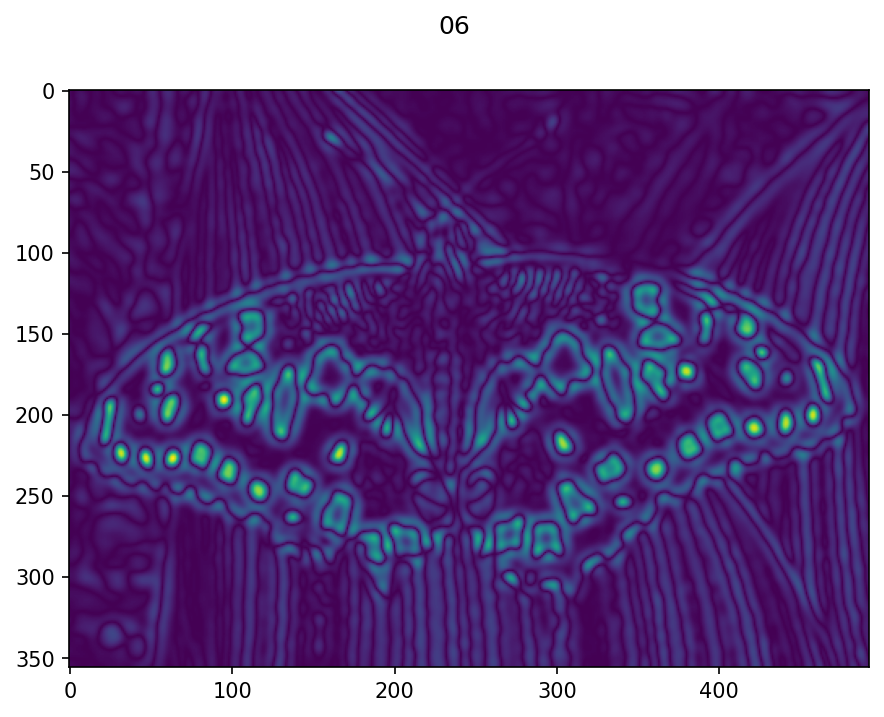

In [11]:
sigma = 2
k = 1.3
levels = 10

#student_code start

scale_space, all_sigmas = filters.get_log_pyramid(imgNormalized, sigma, k, levels)

thirdLevelImg = cv2.normalize(scale_space[:, :, 2], None, 0, 255, cv2.NORM_MINMAX)
thirdLevelImg = np.uint8(thirdLevelImg)

utils.show_plot(thirdLevelImg, "06", "task1_filtered.png")
#student_code end

### 2. Blob detection

Perform the first step of the non-maximum suppression by setting the values in the scale space below a certain threshold to zero. Then, look for maxima in a defined local neighbourhood, in this case: the 26-connection. ***skimage.feature.peak_local_max(..)*** is useful to obtain local maxima. Complete method ***utils.show_blobs(..)*** and plot the blobs.


***Submission:*** Save the image including the blobs as **task1_blobs_full.png** (threshold around 0.3).

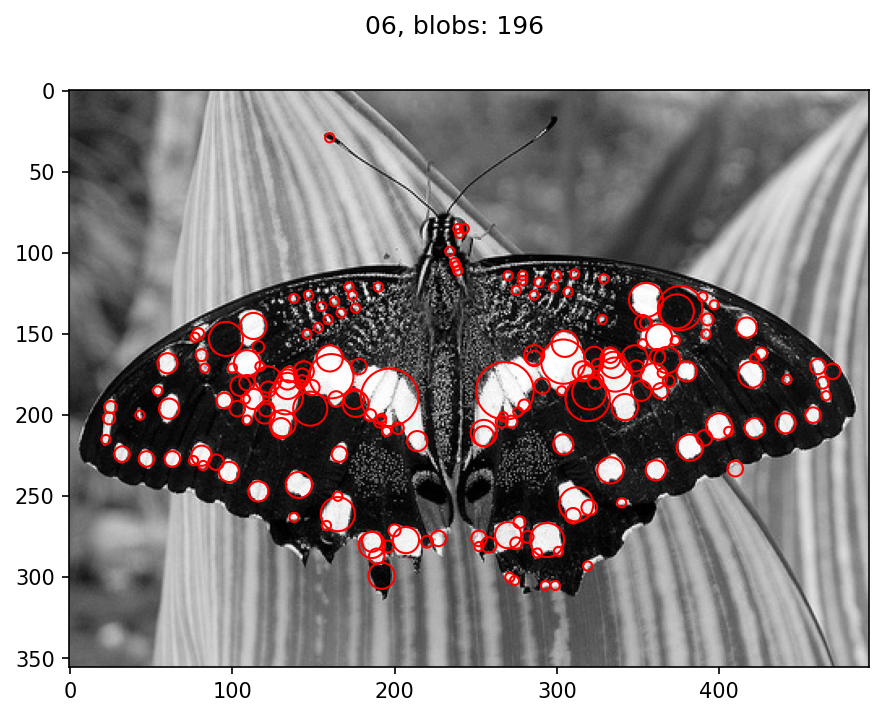

In [4]:
thres = 0.3

#student_code start


def findPeaks(scaleSpace):
    peaks = []

    for l in range(levels): # Iterate over levels
        for i in range(1, scaleSpace.shape[0] - 1):  # Iterate over rows
            for j in range(1, scaleSpace.shape[1] - 1):  # Iterate over columns
                
                if(scaleSpace[i, j, l] < thres): continue # discard if below threshold

                peakPerLvl = np.zeros(3, np.float32)  # [prevLvlVal, currentLvlVal, nextLvlVal]
                coords = peak_local_max(scaleSpace[i - 1 : i + 2, j - 1 : j + 2, l], exclude_border=False)
                
                # discard if not local maximum in l-th level
                if coords.size == 0 : continue
                if(scaleSpace[i, j, l] < np.max([scaleSpace[row + (i - 1), col + (j - 1), l] for row, col in coords])): continue
                
                # Set the current level value
                peakPerLvl[1] = scaleSpace[i, j, l]

                # Previous level (l - 1) find maximum in the 3x3 neighborhood
                if l - 1 >= 0:
                    coords = peak_local_max(scaleSpace[i - 1 : i + 2, j - 1 : j + 2, l - 1], exclude_border=False)
                    if coords.size > 0:
                        peakPerLvl[0] = np.max([scaleSpace[row + (i - 1), col + (j - 1), l - 1] for row, col in coords])
                
                # Next level (l + 1) find maximum in the 3x3 neighborhood
                if l + 1 < levels:
                    coords = peak_local_max(scaleSpace[i - 1 : i + 2, j - 1 : j + 2, l + 1], exclude_border=False)
                    if coords.size > 0:
                        peakPerLvl[2] = np.max([scaleSpace[row + (i - 1), col + (j - 1), l + 1] for row, col in coords])

                # Find the index of the max value in peakPerLvl
                if(np.argmax(peakPerLvl) == 1): peaks.append([i, j, l])
    
    return np.array(peaks)

peaks = findPeaks(scale_space)
utils.show_blobs(img, peaks, all_sigmas, "06", "task1_blobs_full.png")
#student_code end


### 3. Evaluation 

Apply the process to a half-sized version of the input image. Plot your results as well with ***utils.show_blobs(..)***.

_***HINT:***_
_cv2.resize(..)_


***Submission:*** Save the result as **task1_blobs_half.png**.

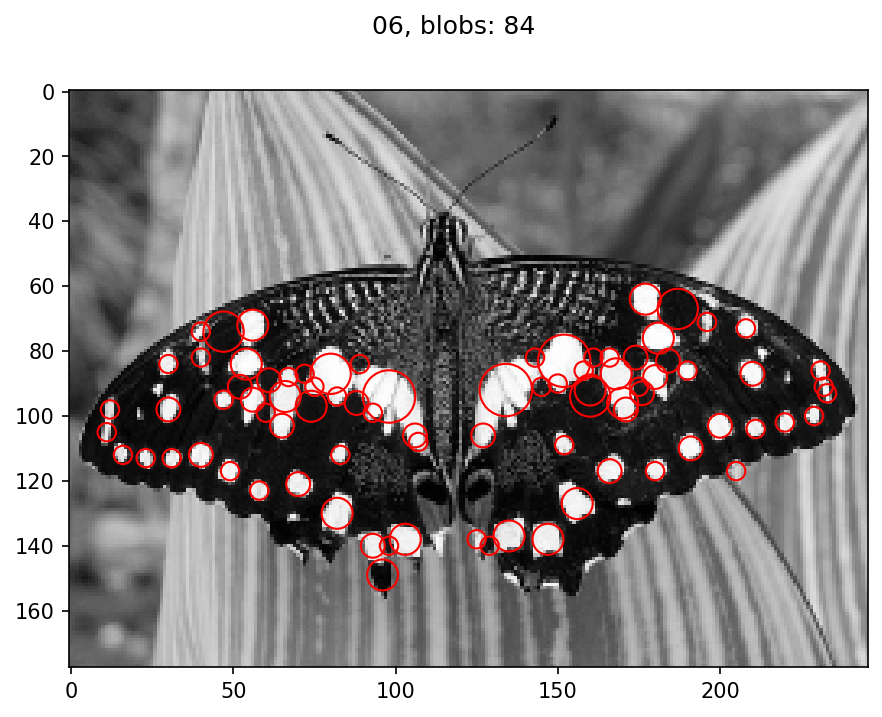

In [5]:
#student_code start
imgHalf = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
imgHalfNormalized = imgHalf / 255.0

scale_spaceHalf, all_sigmasHalf = filters.get_log_pyramid(imgHalfNormalized, sigma, k, levels)

peaksHalf = findPeaks(scale_spaceHalf)
utils.show_blobs(imgHalf, peaksHalf, all_sigmasHalf, "06", "task1_blobs_half.png")

#student_code end

*** 
#### Taking a close look at the detected blobs on different image scales, is the method able to find blobs in a scale-invariant way? What could be reasons for observed errors or inaccurately detected blobs? 

#ANSWER HERE

We observe that we are now detecting fewer blobs. Possible reasons as to why this happens are:
* Loss of features due to the downscaling, so certain blobs are harder to detect. This explains why the blobs missing are the relatively smaller ones (compared to the full sized photo).
* The model depends on the values picked for sigma. There would be a different set of values that could lead to higher detection rates, but that means the implementation is inherently not scale-invariant.


#### 3.1 LoG Response

Pick a detected keypoint and plot the response of the LoG for all scales in both image versions. The outcome should be a 2D plot where the x-axis represents the scale of the filter and the y-axis the filter response at the selected keypoint position. 

_***HINT:***_
_plt.plot(..)_

[ 29 160   0]


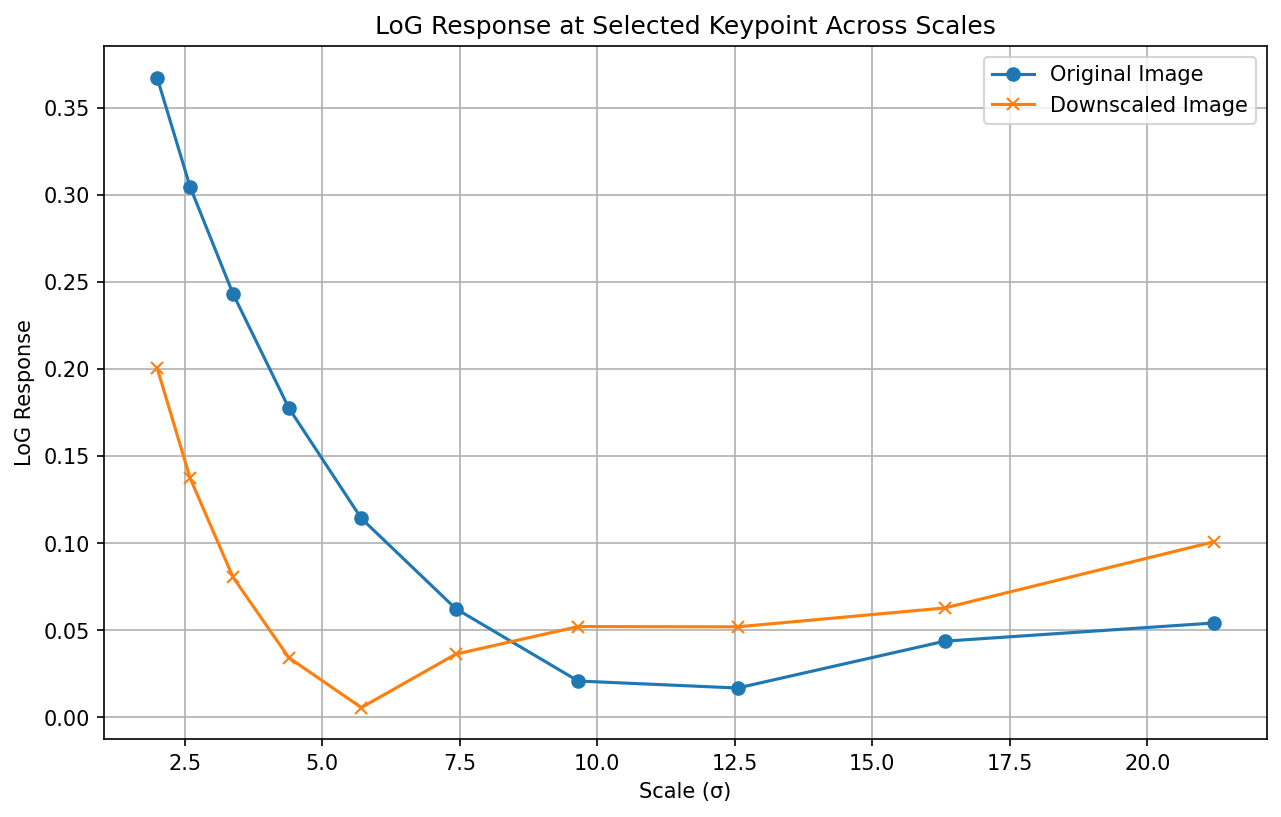

In [ ]:
#student_code start

keypoint = peaks[0]
x = keypoint[0]
y = keypoint [1]
print(keypoint)

responses_orig = [scale_space[x, y, i] for i in range(0, levels)]
responses_downscaled= [scale_spaceHalf[int(x/2), int(y/2), i] for i in range(0, levels)]

plt.plot(all_sigmas, responses_orig, label='Original Image', marker='o')
plt.plot(all_sigmas, responses_downscaled, label='Downscaled Image', marker='x')
plt.xlabel('Scale (σ)')
plt.ylabel('LoG Response')
plt.title('LoG Response at Selected Keypoint Across Scales')
plt.legend()
plt.grid(True)
plt.show()

#student_code end

*** 
#### Describe and explain the difference between the two LoG response curves.

#ANSWER_HERE

Picking the same keypoint we can observe that the trajectories along the x-axis are rather similar as expected, showcasing a maximum for $\sigma = 2$. The main difference though, would be the fact that the response for the downscaled image is much smaller. The response for the original image has a peak that is slightly above $0.35$ while for the downscaled image it stands at $0.2$ which means it won't even qualify as a keypoint as it is now below the threshold set at $0.3$.

This is because there is a loss of features, particularly of finer details, due to the downsampling effect. For the LoG in the downsampled image, it in now more diffucult to detect those features, hence the smaller peak.


#### 3.2 Own Image

Import an image of your choice and apply the process once again. 


***Submission:*** Save the image including blobs with ***utils.show_blobs(..)*** as: **task1_blobs_own.png**

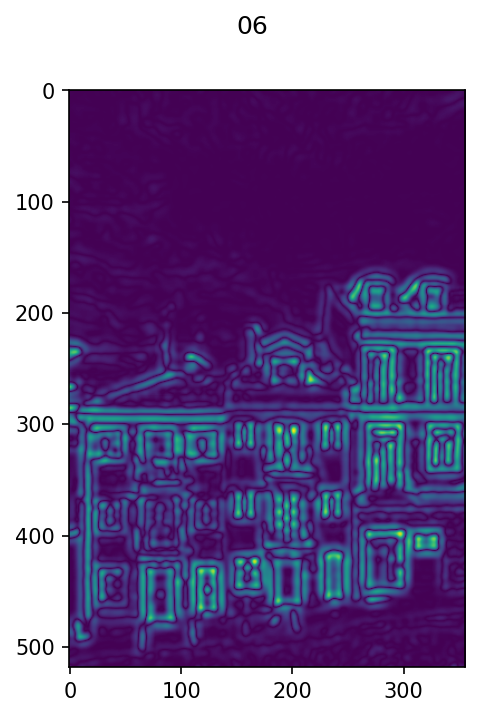

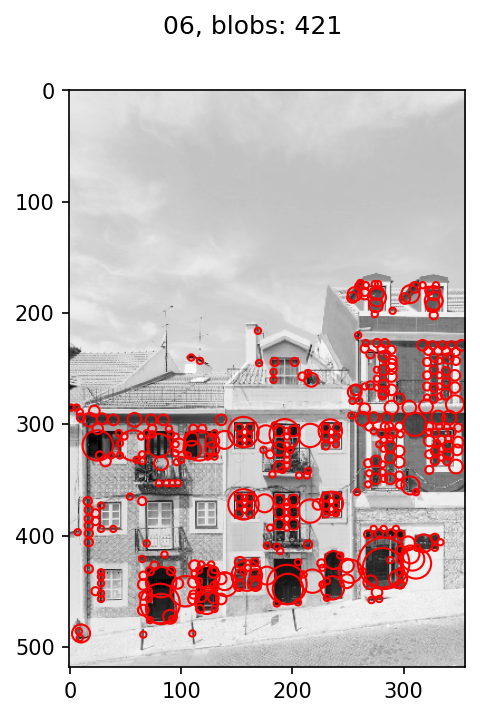

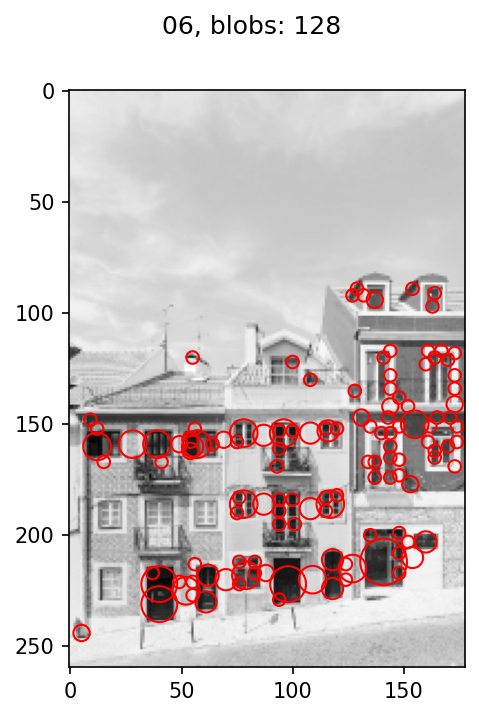

[173 261   0]


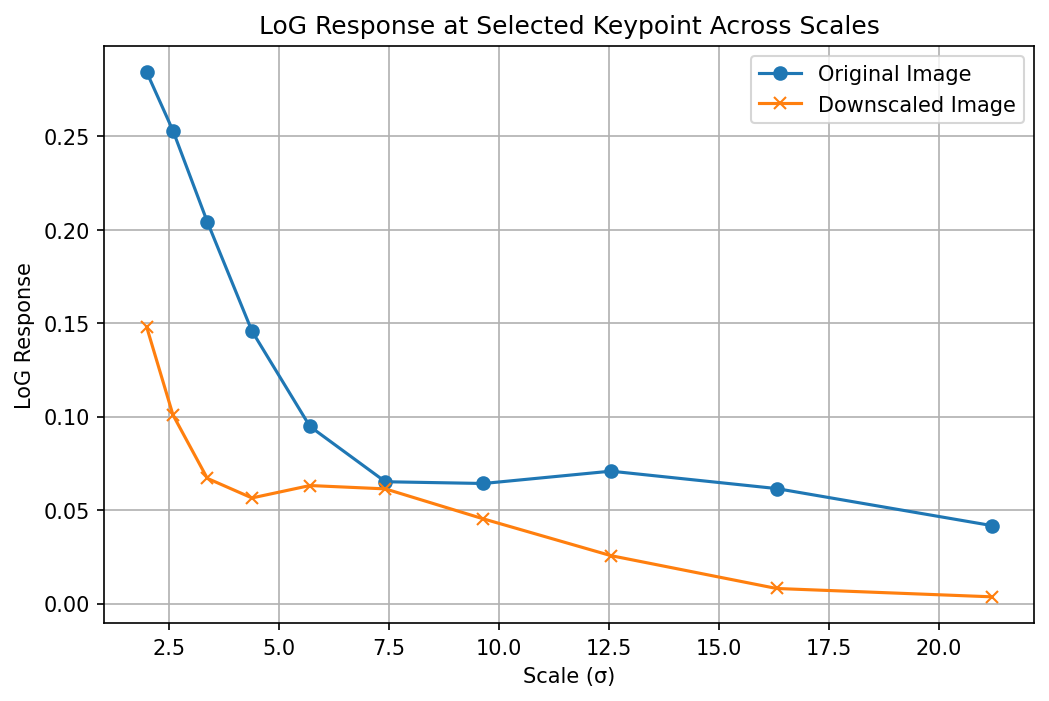

In [24]:
#student_code start

img = cv2.imread("data\\own.png", cv2.IMREAD_GRAYSCALE)
# imgHalf = cv2.resize(img, None, fx=0.3, fy=0.3, interpolation=cv2.INTER_LINEAR)
# cv2.imwrite("data\\own2.png", imgHalf)
imgNormalized = img / 255.0

scale_space, all_sigmas = filters.get_log_pyramid(imgNormalized, sigma, k, levels)
thirdLevelImg = cv2.normalize(scale_space[:, :, 2], None, 0, 255, cv2.NORM_MINMAX)
thirdLevelImg = np.uint8(thirdLevelImg)

utils.show_plot(thirdLevelImg, "06", "task1_filtered_own.png")

peaks = findPeaks(scale_space)
utils.show_blobs(img, peaks, all_sigmas, "06", "task1_blobs_own.png")

imgHalf = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
imgHalfNormalized = imgHalf / 255.0

scale_spaceHalf, all_sigmasHalf = filters.get_log_pyramid(imgHalfNormalized, sigma, k, levels)

peaksHalf = findPeaks(scale_spaceHalf)
utils.show_blobs(imgHalf, peaksHalf, all_sigmasHalf, "06", "task1_blobs_half_own.png")

keypoint = peaks[0]
x = keypoint[0]
y = keypoint [1]
print(keypoint)

responses_orig = [scale_space[x, y, i] for i in range(0, levels)]
responses_downscaled= [scale_spaceHalf[int(x/2), int(y/2), i] for i in range(0, levels)]

plt.plot(all_sigmas, responses_orig, label='Original Image', marker='o')
plt.plot(all_sigmas, responses_downscaled, label='Downscaled Image', marker='x')
plt.xlabel('Scale (σ)')
plt.ylabel('LoG Response')
plt.title('LoG Response at Selected Keypoint Across Scales')
plt.legend()
plt.grid(True)
plt.show()

#student_code end